# Analyze SARS-CoV-2 Spike Glycoprotein Variants
[Work in progress]

This notebook queries the Knowledge Graph for variants in the SARS-CoV S gene and analyzes mutations that may affect the ACE2 binding to the Spike Glycoprotein as well we mutations at the polybasic cleavage site. In addition, it analyzes the geographic locations of the variants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

In [3]:
import py2neo
py2neo.__version__

'2021.2.3'

#### Connect to COVID-19-Community Knowledge Graph

In [4]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

## Analysis of missense mutations in the SARS-CoV-2 Spike glycoprotein

![Spike protein](../../docs/Spikeprotein.png)

**a.** ACE2 receptor binding domain of the SARS-CoV-2 spike protein. **b.** Polybasic cleavage site with three predicted O-glycosylation sites.

Reference: Andersen, K.G., Rambaut, A., Lipkin, W.I. et al. The proximal origin of SARS-CoV-2. Nat Med 26, 450–452 (2020). [doi:10.1038/s41591-020-0820-9](https://doi.org/10.1038/s41591-020-0820-9)

### Query KG for the S gene and its gene product

Mutation data below are based on the Wuhan-Hu-1 ([NC_045512](http://identifiers.org/resolve?query=ncbiprotein:NC_045512)) reference sequence.

In [5]:
gene_name = 'S'
taxonomy_id = 'taxonomy:2697049' # SARS-CoV-2

In [6]:
query = """
MATCH (g:Gene{name: $gene_name, taxonomyId: $taxonomy_id})-[:ENCODES]->(p:Protein) 
RETURN g.name AS geneName, p.accession AS proteinAccession, p.sequence AS proteinSequence
"""
df = graph.run(query, gene_name=gene_name, taxonomy_id=taxonomy_id).to_data_frame()

In [7]:
df.head()

,geneName,proteinAccession,proteinSequence
0,S,uniprot:P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1,S,uniprot:A0A7M1FEQ3,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSX...
2,S,uniprot:A0A7L7W2Y0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,S,uniprot:A0A7H0A470,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4,S,uniprot:A0A7H4JLD1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [8]:
seq = df['proteinSequence'].iloc[0]

In [9]:
print('Sequence of the Spike glycoprotein:', len(seq), 'residues')
print(seq)

Sequence of the Spike glycoprotein: 1273 residues
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQD

### Type of Variants in Spike glycoprotein

List of variant types and consequences:

https://uswest.ensembl.org/info/genome/variation/prediction/classification.html

https://uswest.ensembl.org/info/genome/variation/prediction/predicted_data.html#consequences

In [10]:
host_taxonomy_id = 'taxonomy:9606' # human

In [11]:
query = """
MATCH (g:Gene{name: $gene_name, taxonomyId: $taxonomy_id})-[:HAS_VARIANT]->(v:Variant)
       <-[:HAS_VARIANT]-(s:Strain)
WHERE s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT v.variantType, v.variantConsequence, count(s)
ORDER BY v.variantType
"""

In [12]:
df = graph.run(query, gene_name=gene_name, taxonomy_id=taxonomy_id, host_taxonomy_id=host_taxonomy_id).to_data_frame()

In [13]:
df.head(20)

,v.variantType,v.variantConsequence,count(s)
0,Deletion,inframe_deletion,1053073
1,Deletion,frameshift_variant,3516
2,Deletion,stop_gained,6
3,Indel,frameshift_variant,16
4,Indel,protein_altering_variant,56
5,Insertion,inframe_insertion,999
6,Insertion,frameshift_variant,294
7,Insertion,stop_gained,10
8,Insertion,protein_altering_variant,414
9,Insertion,coding_sequence_variant,1


### Frequency of mutation by sequence position
Receptor-binding domain contact residues and O-linked glycan sites are highlighted in the plot below.

In [14]:
query = """
MATCH (g:Gene{name: $gene_name, taxonomyId: $taxonomy_id})-[:HAS_VARIANT]->
      (v:Variant{variantConsequence:'missense_variant'})<-[:HAS_VARIANT]-(s:Strain)
WHERE s.hostTaxonomyId = $host_taxonomy_id
RETURN v.proteinPosition AS proteinPosition, v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
       s.name as strain, s.collectionDate AS collectionDate
ORDER by proteinPosition
"""

In [15]:
df = graph.run(query, gene_name=gene_name, taxonomy_id=taxonomy_id, 
               host_taxonomy_id=host_taxonomy_id).to_data_frame()

In [16]:
df.head(10)

,proteinPosition,geneVariant,proteinVariant,strain,collectionDate
0,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/USA/UT-UPHL-2104906870/2021,2021-01-15
1,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/Germany/BW-RKI-I-147538/2021,2021-04-25
2,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/Greece/V970/2021,2021-04-28
3,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/Greece/V909/2021,2021-04-28
4,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/USA/TX-HMH-MCoV-41060/2020,2020-07-21
5,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/USA/TX-HMH-MCoV-37419/2020,2020-12-05
6,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/USA/TX-HMH-MCoV-37420/2020,2020-12-04
7,2,S:c.6ttT>ttA,S:p.2F>L,SARS-CoV-2/human/USA/CA-CDC-ASC210000984/2021,2021-03-01
8,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/USA/TX-HMH-MCoV-32950/2020,2020-12-16
9,2,S:c.6ttT>ttA,S:p.2F>L,hCoV-19/Brazil/SP-IB_100065/2021,2021-03-10


In [17]:
positions = df['proteinPosition'].values

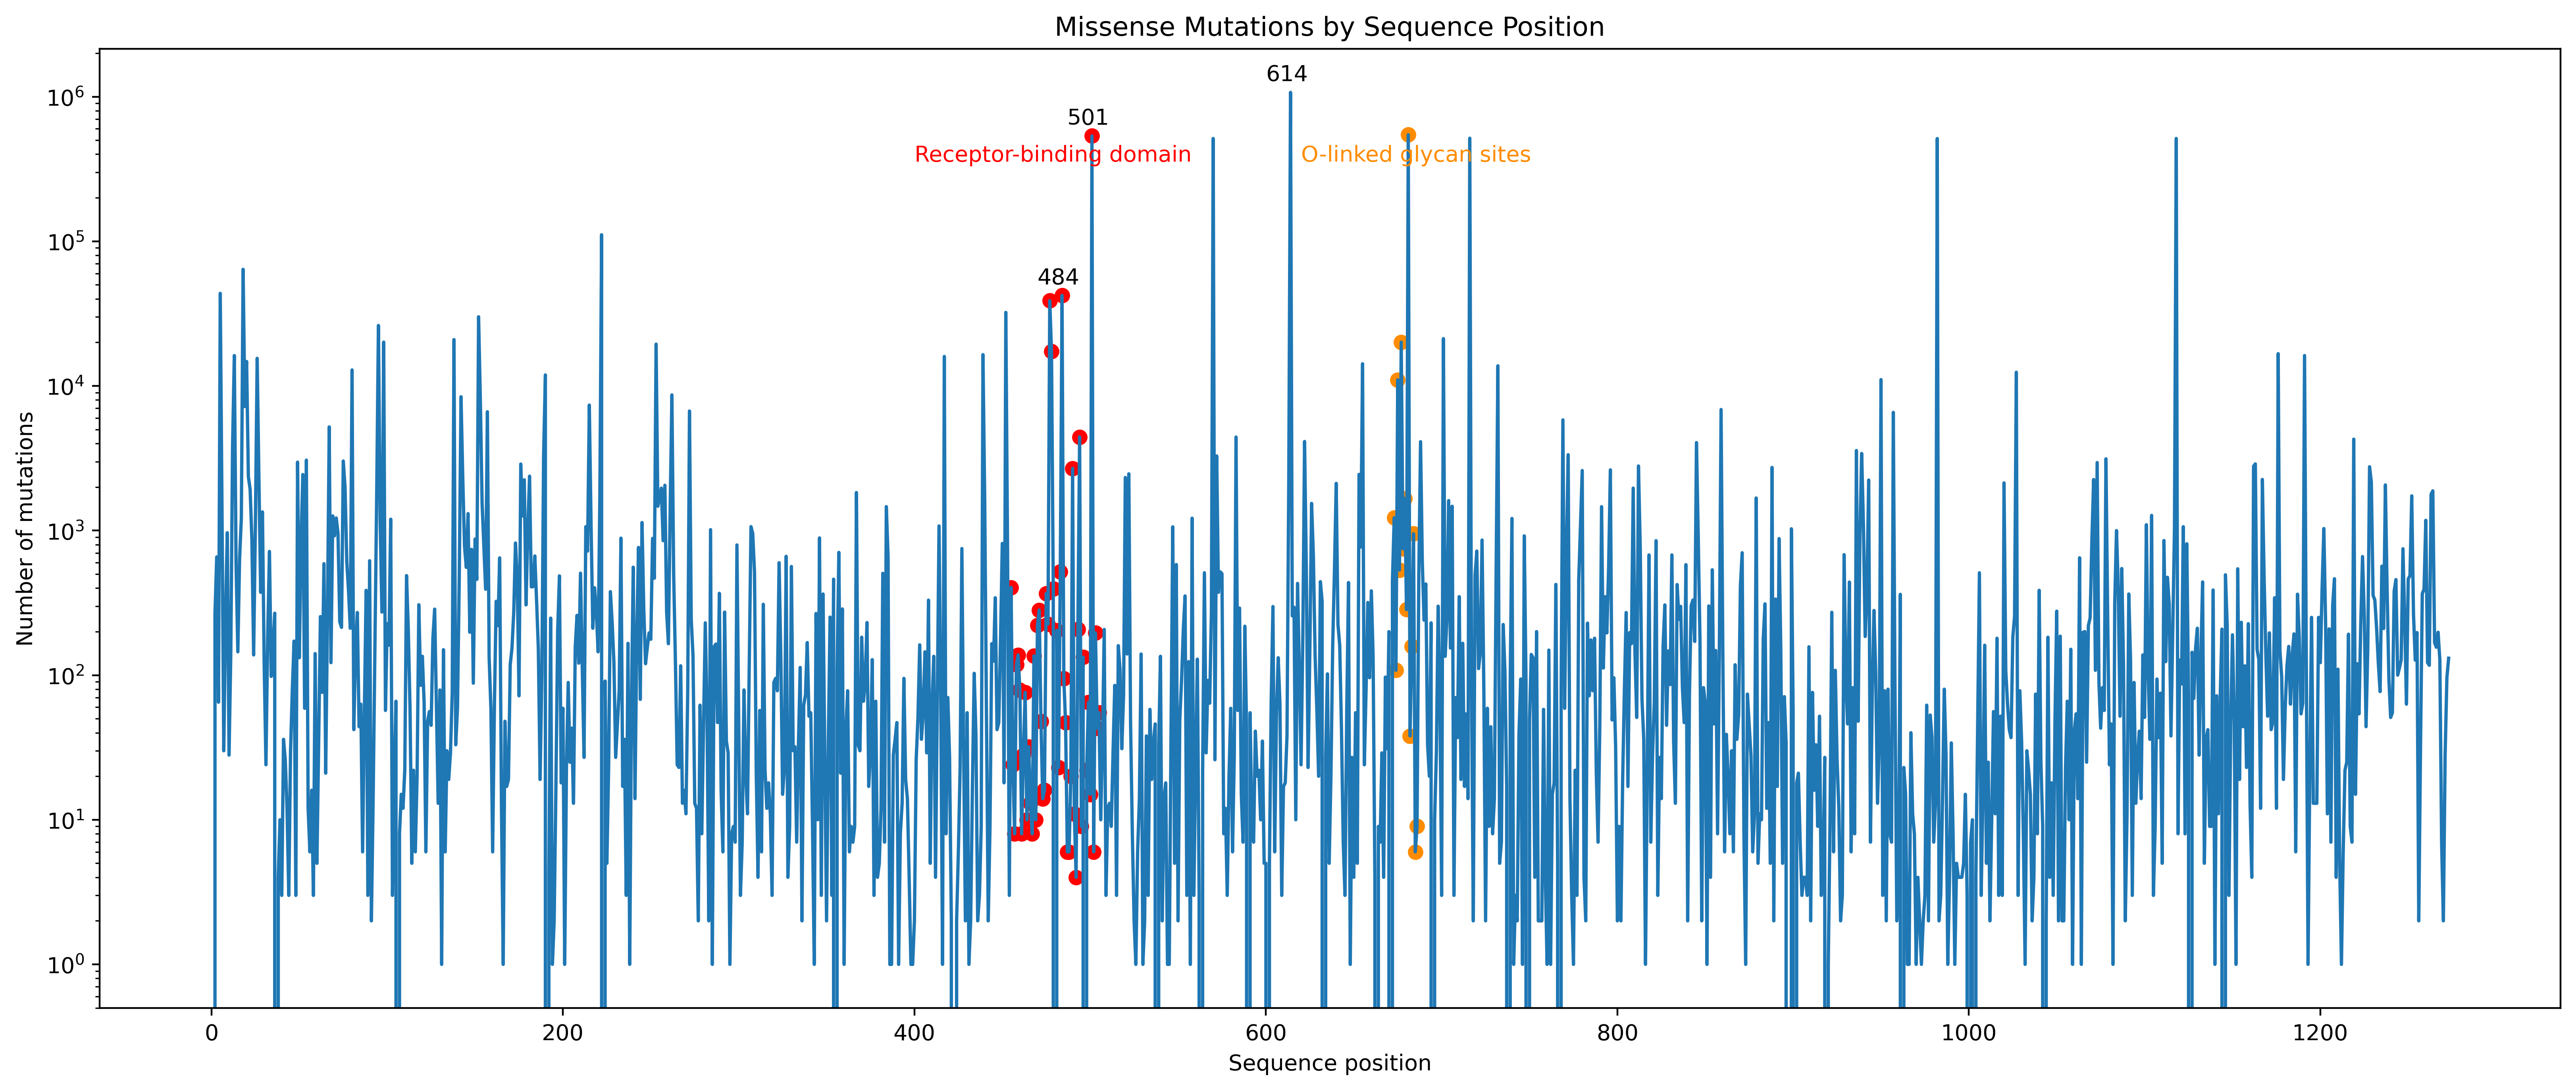

In [27]:
x = np.arange(len(seq)+1)
y = np.zeros(len(seq)+1)
for p in positions:
    y[p] += 1

plt.rcParams['figure.dpi'] = 400
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(x, y)
plt.yscale('log')
plt.xlabel('Sequence position')
plt.ylabel('Number of mutations')
plt.title('Missense Mutations by Sequence Position')

# receptor-binding domain (RBD) contact residues in red
rbd = (x >= 455) & (x <= 505)
plt.scatter(x[rbd], y[rbd], color='red') 

# O-linked glycan sites in orange
ogs = (x >= 673) & (x <= 686)
plt.scatter(x[ogs], y[ogs], color='darkorange') 

# annotate important residues
offset = -14
plt.annotate('484', xy=(484+offset, y[484]*1.2))
plt.annotate('501', xy=(501+offset, y[501]*1.2))
plt.annotate('614', xy=(614+offset, y[614]*1.2))
plt.annotate('Receptor-binding domain', xy=(400, y.max()/3), color='red')
plt.annotate('O-linked glycan sites', xy=(620, y.max()/3), color='darkorange')

plt.show()

##### Mutations at position 501

In [19]:
df.query('proteinPosition == 501').head(10)

,proteinPosition,geneVariant,proteinVariant,strain,collectionDate
774952,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/IL-C21WGS0918/2021,2021-04-23
774953,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/UT-UPHL-2104906870/2021,2021-01-15
774954,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/MA-Yale-5278/2020,2020-11-29
774955,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/MA-Yale-5117/2021,2021-01-11
774956,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/MA-Yale-5088/2021,2021-01-19
774957,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/MA-Yale-5138/2021,2021-01-04
774958,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/MA-Yale-5037/2021,2021-02-04
774959,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/MA-Yale-4987/2021,2021-01-11
774960,501,S:c.1502aAt>aCt,S:p.501N>T,hCoV-19/USA/NY-NYGC-999-VTM1-MVBN765/2021,2021-01-26
774961,501,S:c.1502aAt>aCt,S:p.501N>T,SARS-CoV-2/human/USA/UT-UPHL-2104509556/2020,2020-08-19


### Strains with mutations in the Spike glycoprotein receptor-binding domain (RBD)

Six amino acids in the RBD of the spike protein have been shown to be critical for binding to ACE2 receptors: 

L455, F486, Q493, S494, N501, Y505

Python uses zero-based indices, so we subtract 1 to find the position in the sequence.

In [20]:
print(seq[455-1], seq[486-1], seq[493-1], seq[494-1], seq[501-1], seq[505-1])

L F Q S N Y


#### The following variants are missense mutations in the RBD

In [21]:
query = """
MATCH (g:Gene{name: $gene_name, taxonomyId: $taxonomy_id})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [455, 486, 493, 494, 501, 505] AND s.hostTaxonomyId = 'taxonomy:9606'
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, l.name AS location, 
labels(l) AS locationType, s.id AS strainId
"""
df = graph.run(query, gene_name=gene_name, taxonomy_id=taxonomy_id).to_data_frame()

In [22]:
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,location,locationType,strainId
0,S:c.1365ttG>ttT,S:p.455L>F,SARS-CoV-2/human/USA/CA-CDC-ASC210059542/2021,2021-05-06,California,"[Admin1, Location]",insdc:MZ280761
1,S:c.1365ttG>ttT,S:p.455L>F,SARS-CoV-2/human/USA/MI-CDC-STM-000068869/2021,2021-05-01,Michigan,"[Admin1, Location]",insdc:MZ279385
2,S:c.1365ttG>ttT,S:p.455L>F,hCoV-19/USA/CO-CDPHE-2100944425/2021,2021-04-18,Colorado,"[Admin1, Location]",https://www.gisaid.org/EPI_ISL_2309316
3,S:c.1365ttG>ttT,S:p.455L>F,hCoV-19/Denmark/DCGC-104006/2021,2021-05-17,Denmark,"[Country, Location]",https://www.gisaid.org/EPI_ISL_2301334
4,S:c.1365ttG>ttT,S:p.455L>F,hCoV-19/USA/WA-UW-21050504698/2021,2021-05-05,Washington,"[Admin1, Location]",https://www.gisaid.org/EPI_ISL_2299349


#### Find variants around these critical residues within a 5 amino acid window (+/- 2 residues)

In [23]:
query = """
MATCH (g:Gene{name: $gene_name, taxonomyId: $taxonomy_id})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [453,454,455,456,457, 484,485,486,487,488, 491,492,493,494,495,496,
                            499,500,501,502,503,504,505,506,507] 
      AND s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, s.gender AS gender, s.age as age, 
l.name AS location, l.location AS coordinates, labels(l) AS locationType, s.id AS strainId
"""
df = graph.run(query, gene_name=gene_name, taxonomy_id=taxonomy_id, host_taxonomy_id=host_taxonomy_id).to_data_frame()
df.fillna('', inplace=True)
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,gender,age,location,coordinates,locationType,strainId
0,S:c.1358tAt>tTt,S:p.453Y>F,SARS-CoV-2/human/USA/UT-UPHL-2104884719/2020,2020-08-12,,,Utah,"(-111.75103, 39.25024)","[Admin1, Location]",https://www.gisaid.org/EPI_ISL_2279735
1,S:c.1358tAt>tTt,S:p.453Y>F,hCoV-19/Denmark/DCGC-66933/2020,2020-11-09,,,Denmark,,"[Country, Location]",https://www.gisaid.org/EPI_ISL_1875504
2,S:c.1358tAt>tTt,S:p.453Y>F,hCoV-19/Denmark/DCGC-65550/2020,2020-11-16,,,Denmark,,"[Country, Location]",https://www.gisaid.org/EPI_ISL_1874121
3,S:c.1358tAt>tTt,S:p.453Y>F,hCoV-19/Denmark/DCGC-63880/2020,2020-11-09,,,Denmark,,"[Country, Location]",https://www.gisaid.org/EPI_ISL_1872451
4,S:c.1358tAt>tTt,S:p.453Y>F,hCoV-19/Denmark/DCGC-63733/2020,2020-10-26,,,Denmark,,"[Country, Location]",https://www.gisaid.org/EPI_ISL_1872304


### Find strains with mutations in the polybasic cleavage site
This site has three predicted O-glycosylation sites:
    
S673, T678, S686

In [24]:
print(seq[673-1], seq[678-1], seq[686-1])

S T S


In [25]:
query = """
MATCH (g:Gene{name: $gene_name, taxonomyId: $taxonomy_id})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [673, 678, 686] 
      AND s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, s.gender AS gender, s.age as age, 
l.name AS location, labels(l) AS locationType, s.id AS strainId
"""
df = graph.run(query, gene_name=gene_name, taxonomy_id=taxonomy_id, host_taxonomy_id=host_taxonomy_id).to_data_frame()
df.fillna('', inplace=True)
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,gender,age,location,locationType,strainId
0,S:c.2017Agt>Ggt,S:p.673S>G,SARS-CoV-2/human/USA/PA-CDC-LC0053849/2021,2021-04-28,,,Pennsylvania,"[Admin1, Location]",insdc:MZ179840
1,S:c.2017Agt>Ggt,S:p.673S>G,hCoV-19/Denmark/DCGC-61905/2021,2021-01-11,,,Denmark,"[Country, Location]",https://www.gisaid.org/EPI_ISL_1870476
2,S:c.2017Agt>Ggt,S:p.673S>G,SARS-CoV-2/human/USA/NY-CDC-LC0046466/2021,2021-04-12,,,New York,"[Admin1, Location]",insdc:MZ071173
3,S:c.2017Agt>Ggt,S:p.673S>G,hCoV-19/Denmark/DCGC-83453/2021,2021-01-11,,,Denmark,"[Country, Location]",https://www.gisaid.org/EPI_ISL_1892464
4,S:c.2017Agt>Ggt,S:p.673S>G,hCoV-19/Denmark/DCGC-77067/2021,2021-01-11,,,Denmark,"[Country, Location]",https://www.gisaid.org/EPI_ISL_1885638


#### Find variants around these residues within a 5 amino acid window (+/- 2 residues)

In [26]:
query = """
MATCH (g:Gene{name: $gene_name, taxonomyId: $taxonomy_id})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [671,672,673,674,675, 676,677,678,679,670, 684,685,686,687,688] 
      AND s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, s.gender AS gender, s.age as age, l.name AS location, 
labels(l) AS locationType, s.id AS strainId
ORDER BY v.proteinVariant, s.collectionDate
"""
df = graph.run(query, gene_name=gene_name, taxonomy_id=taxonomy_id, host_taxonomy_id=host_taxonomy_id).to_data_frame()
df.fillna('', inplace=True)
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,gender,age,location,locationType,strainId
0,S:c.2017Agt>Cgt,QHD43416.1:p.673S>R,hCoV-19/USA/CA-ALSR-3047/2020,2020-08-27,,,San Diego,"[City, Location]",https://www.gisaid.org/EPI_ISL_635812
1,S:c.2033aCt>aGt,QHD43416.1:p.678T>S,COG-UK/LOND-124C522,2020-04-10,,,England,"[Admin1, Location]",https://www.gisaid.org/EPI_ISL_492865
2,S:c.2054cGt>cAt,QHD43416.1:p.685R>H,SARS-CoV-2/human/USA/WA-RML-6/2020,2020-05-11,,,King County,"[Admin2, Location]",insdc:MT982404
3,S:c.2058agT>agA,QHD43416.1:p.686S>R,hCoV-19/Israel/n4278/2020,2020-03-24,,,Kfar Saba,"[City, Location]",https://www.gisaid.org/EPI_ISL_483706
4,S:c.2058agT>agG,QHD43416.1:p.686S>R,hCoV-19/UnitedArabEmirates/0292/2020,2020-05-18,,,United Arab Emirates,"[Country, Location]",https://www.gisaid.org/EPI_ISL_698471
